### Feature Engineering
---

#### Preparing the features for KMeans Clustering
##### Using RFM features (Recency, Frequency and Monetary Value)
##### Recency: How many days since customers' last purchase
##### Frequency: How many times customers have purchased
##### Monetary Value: Sum total monetary amount that customers' spent

#### Load the dependencies and the data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# setting for interpretable numbers on the read display
pd.options.display.float_format = '{:20.2f}'.format

# show all columns on output
pd.set_option('display.max_columns', 999)

In [5]:
df = pd.read_csv('online_transactions_cleaned.csv')
# Overwriting the original dataframe to exclude 2010 records
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Convert to datetime
df = df[df['InvoiceDate'].dt.year != 2010]
df.head(1).T

,26056
InvoiceNo,539993
StockCode,22386
Description,JUMBO BAG PINK POLKADOT
Quantity,10
InvoiceDate,2011-01-04 10:00:00
UnitPrice,1.95
CustomerID,13313.00
Country,United Kingdom
InvoiceDateYear,2011
InvoiceDateMonth,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370284 entries, 26056 to 396339
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         370284 non-null  int64         
 1   StockCode         370284 non-null  object        
 2   Description       370284 non-null  object        
 3   Quantity          370284 non-null  int64         
 4   InvoiceDate       370284 non-null  datetime64[ns]
 5   UnitPrice         370284 non-null  float64       
 6   CustomerID        370284 non-null  float64       
 7   Country           370284 non-null  object        
 8   InvoiceDateYear   370284 non-null  int64         
 9   InvoiceDateMonth  370284 non-null  int64         
 10  InvoiceDateDay    370284 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(5), object(3)
memory usage: 33.9+ MB


In [7]:
print(df['InvoiceDateYear'].value_counts())

InvoiceDateYear
2011    370284
Name: count, dtype: int64


In [8]:
# Calculate the sum of monetary values
df["SalesLineTotal"] = df['Quantity'] * df['UnitPrice']

In [9]:
# df

In [10]:
# Firstly, aggregate data by grouping by CustomerID (want a unique set of CustomerID's)
# Secondly compute the aggregates for the RFM features

# groupby CustomerID without setting it as index columns and using .agg()
aggregated_df = df.groupby(by="CustomerID", as_index=False)\
    .agg(
        MonetaryValue=("SalesLineTotal", "sum"),
        Frequency=("InvoiceNo", "nunique"), # Number of unique invoices per customer
        LastInvoiceDate=("InvoiceDate", "max") # The most recent transaction in the dataset
    )
aggregated_df.head(5)

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate
0,12346.00,77183.60,1,2011-01-18 10:01:00
1,12347.00,3598.21,6,2011-12-07 15:52:00
2,12348.00,784.44,3,2011-09-25 13:13:00
3,12349.00,1457.55,1,2011-11-21 09:51:00
4,12350.00,294.40,1,2011-02-02 16:01:00


In [11]:
# Calculate the Recency feature values assuming 
# c the maximum invoice date to help us calculate recency values
# the dataset is from 2011 and using todays date will result in extremely large values
# IRL we would use the current date stamp
max_invoice_date = aggregated_df["LastInvoiceDate"].max()
# aggregate LastInvoiceDate to measure Recency in days
aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastInvoiceDate"]).dt.days
aggregated_df.head(5)

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency
0,12346.00,77183.60,1,2011-01-18 10:01:00,325
1,12347.00,3598.21,6,2011-12-07 15:52:00,1
2,12348.00,784.44,3,2011-09-25 13:13:00,74
3,12349.00,1457.55,1,2011-11-21 09:51:00,18
4,12350.00,294.40,1,2011-02-02 16:01:00,309


#### Check for outliers
##### Outliers can affect the data analysis. 
##### In clustering, it is important to note that centroids may struggle to find the outliers and therefore will have difficulty stabilising.

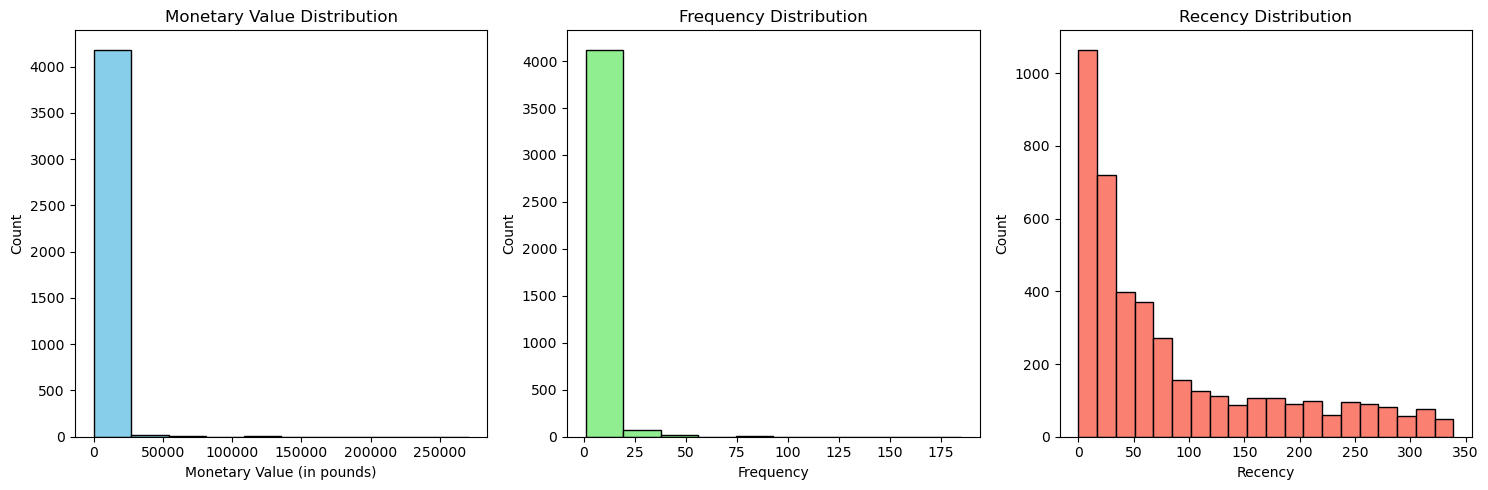

In [13]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.hist(aggregated_df["MonetaryValue"], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value (in pounds)')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(aggregated_df["Frequency"], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.hist(aggregated_df["Recency"], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
# plt.savefig('RFM_histogram_distributions.png', dpi=300)
plt.show()

---
#### Insight:
##### Distribution in Monetary Values and Frequency skewed towards the first bin
##### Recency distribution - Poisson Distribution
---

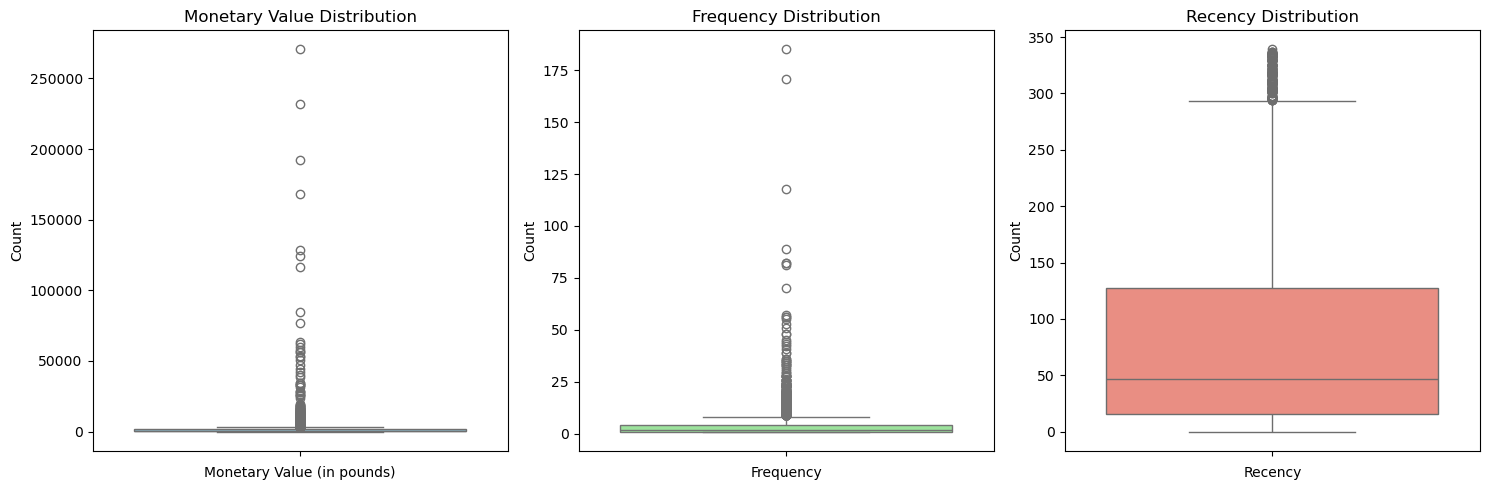

In [15]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(data=aggregated_df["MonetaryValue"], color='skyblue')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value (in pounds)')
plt.ylabel('Count')

plt.subplot(1,3,2)
sns.boxplot(data=aggregated_df["Frequency"], color='lightgreen')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1,3,3)
sns.boxplot(data=aggregated_df["Recency"], color='salmon')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
# plt.savefig('RFM_boxplot_distributions.png', dpi=300)
plt.show()

---
#### Insight:
##### The Monetary Value Boxplot values are concentrated at the lower end with a few extreme outliers reaching up to 250,000 pounds.
##### The Frequency Boxplot indicates that the majority of the frequency values are very low, with a few outliers going up to 175.
##### The Recency feature Boxplot shows a wider spread, with the median around 50 and some outliers reaching up to 350. 
---

#### Strategy: Separate the outliers for further analysis (instead of removing outliers) and use remaining data for KMeans clustering using the IQR.

In [67]:
# Monetary Quartile 1
M_Q1 = aggregated_df["MonetaryValue"].quantile(0.25) # 25th Quantile
# Monetary Quartile 3
M_Q3 = aggregated_df["MonetaryValue"].quantile(0.75) # 75th Quantile
# Monetary InterQuartile range
M_IQR = M_Q3 - M_Q1
monetary_outliers_df = aggregated_df[(aggregated_df['MonetaryValue']>(M_Q3 + 1.5 * M_IQR)) | (aggregated_df['MonetaryValue']<(M_Q1 - 1.5 * M_IQR))].copy()
monetary_outliers_df.describe()
monetary_outliers_df.to_csv('monetary_outliers.csv', index = False)

In [69]:
# Frequency Quartile 1
F_Q1 = aggregated_df["Frequency"].quantile(0.25) # 25th Quantile
# Frequency Quartile 3
F_Q3 = aggregated_df["Frequency"].quantile(0.75) # 75th Quantile
# Frequency InterQuartile range
F_IQR = F_Q3 - F_Q1
frequency_outliers_df = aggregated_df[(aggregated_df['Frequency']>(F_Q3 + 1.5 * F_IQR)) | (aggregated_df['Frequency']<(F_Q1 - 1.5 * F_IQR))].copy()
frequency_outliers_df.describe()
frequency_outliers_df.to_csv('frequency_outliers.csv', index = False)

---
#### Insight:
##### Some of the monetary value outlier statistics are the same as the frequency outlier statistics.
##### For example, the maximum value for both features are equal indicating a clear pattern of a frequently spending customer.
##### A greater frequency results in a greater monetary value.
##### This finding is significant for categorising the outlier values in further analysis.
##### Category 1: Pure Monetary outliers
##### Category 2: Pure Frequency outliers
##### Category 3: Both Monetary and Frequency outliers
---

In [71]:
# Recency Quartile 1
R_Q1 = aggregated_df["Recency"].quantile(0.25) # 25th Quantile
# Recency Quartile 3
R_Q3 = aggregated_df["Recency"].quantile(0.75) # 75th Quantile
# Recency InterQuartile range
R_IQR = R_Q3 - R_Q1
recency_outliers_df = aggregated_df[(aggregated_df['Recency']>(R_Q3 + 1.5 * R_IQR)) | (aggregated_df['Recency']<(R_Q1 - 1.5 * R_IQR))].copy()
recency_outliers_df.describe()
recency_outliers_df.to_csv('recency_outliers.csv', index = False)

In [22]:
# filter the aggregated data for the values which are not outliers by getting the
# aggregated data index which are not those in the monetary outliers dataframe and frequency outliers dataframe
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers_df.index)) & (~aggregated_df.index.isin(frequency_outliers_df.index))]
non_outliers_df.describe()
# non_outliers_df.to_csv('online_transactions_non_outliers.csv', index=False)
# create and save outliers data frame
# Combine all outliers into a single DataFrame
outliers_df = pd.concat([monetary_outliers_df, frequency_outliers_df, recency_outliers_df]).drop_duplicates().reset_index(drop=True)

# Display summary statistics for outliers
print(outliers_df.describe())

                CustomerID        MonetaryValue            Frequency  \
count               714.00               714.00               714.00   
mean              15121.93              7482.89                11.27   
min               12346.00                 3.75                 1.00   
25%               13577.25              1693.10                 3.00   
50%               15069.50              3735.80                 9.00   
75%               16710.25              6041.80                13.00   
max               18283.00            270561.14               185.00   
std                1787.36             19912.50                14.63   

                     LastInvoiceDate              Recency  
count                            714               714.00  
mean   2011-09-09 00:27:59.831932928                91.04  
min              2011-01-04 11:42:00                 0.00  
25%              2011-07-05 16:34:15                 4.00  
50%              2011-11-21 10:00:00               

---
#### Insight:
##### The mean monetary value for non-outlier data is 793.79 pounds and the standard deviation is 728.28 pounds which indicates significantly low variability in the data.
##### The mean frequency value for non-outlier data is 2.50 and the standard deviation is 1.78 which indicates significantly low variability in the data.
---

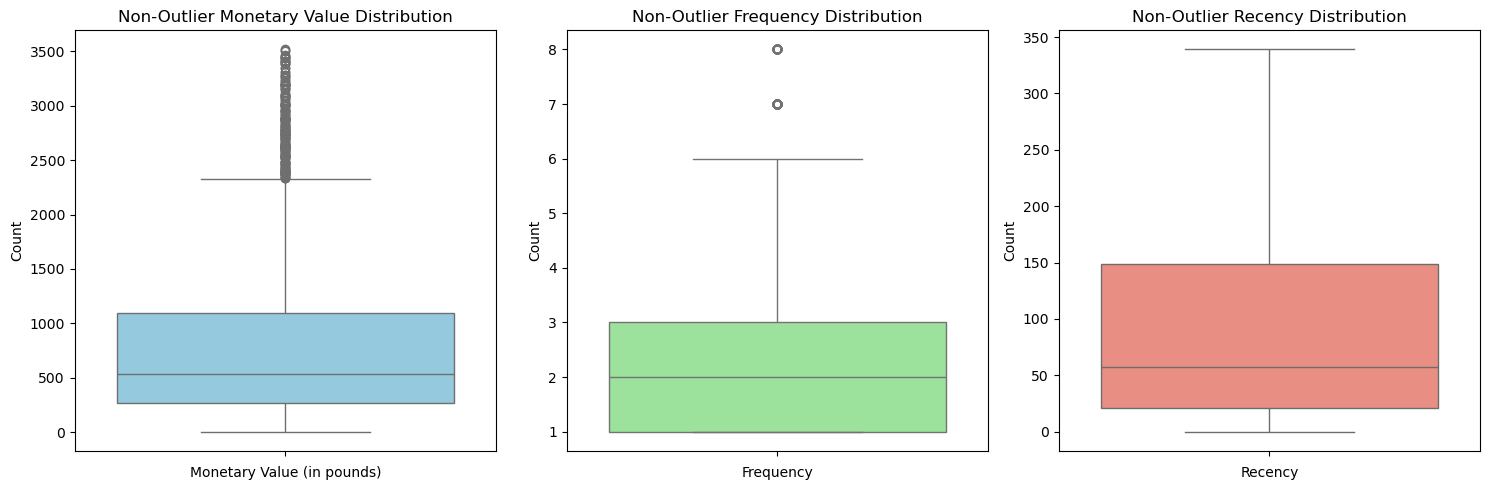

In [24]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(data=non_outliers_df["MonetaryValue"], color='skyblue')
plt.title('Non-Outlier Monetary Value Distribution')
plt.xlabel('Monetary Value (in pounds)')
plt.ylabel('Count')

plt.subplot(1,3,2)
sns.boxplot(data=non_outliers_df["Frequency"], color='lightgreen')
plt.title('Non-Outlier Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1,3,3)
sns.boxplot(data=non_outliers_df["Recency"], color='salmon')
plt.title('Non-Outlier Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
# plt.savefig('RFM_NonOutlier_boxplot_distributions.png', dpi=300)
plt.show()

#### Visualise the RFM customer data in 3D

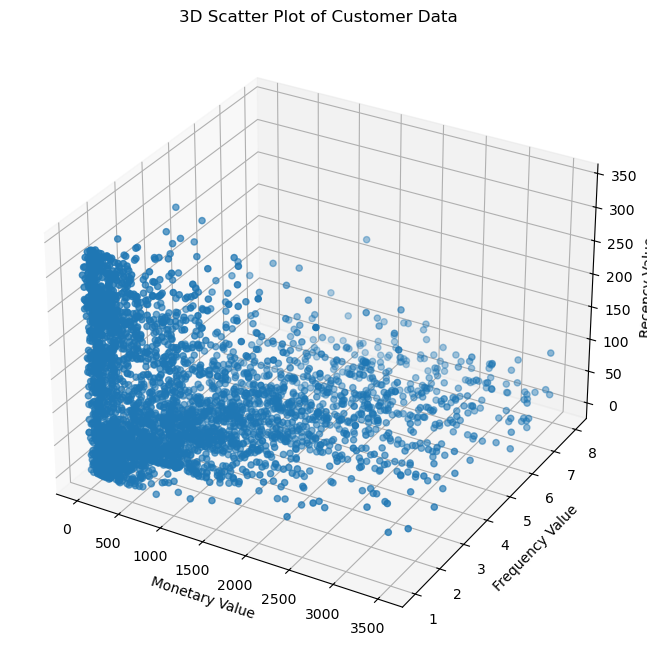

In [26]:
# set the figure
fig = plt.figure(figsize=(8, 8))

# set the axis
ax = fig.add_subplot(projection="3d")

# create the scatter
scatter = ax.scatter(non_outliers_df["MonetaryValue"], non_outliers_df["Frequency"], non_outliers_df["Recency"])

# add labels
ax.set_xlabel("Monetary Value")
ax.set_ylabel("Frequency Value")
ax.set_zlabel("Recency Value")

# set the title of the plot
ax.set_title('3D Scatter Plot of Customer Data')

# plt.savefig('3D_Scatter_Plot_of_Customer_Data.png', dpi=300)
plt.show()

---
#### Insight: 
##### Each feature is on a different scale
---

#### Scaling the data 
##### Using a mean of 0 and 1 as the standard deviation and
##### ensuring that each feature contributes equally for a fair analysis.

In [29]:
# initialise the scaler
scaler = StandardScaler()
# Fit and transform the data - returns numpy array
scaled_data = scaler.fit_transform(non_outliers_df[["MonetaryValue", "Frequency", "Recency"]])
# numpy array of scaled non outlier data
scaled_data

array([[-0.01284347,  0.28381239, -0.20811008],
       [ 0.91152715, -0.84131744, -0.81576892],
       [-0.68580714, -0.84131744,  2.34188685],
       ...,
       [-0.97911295, -0.84131744,  0.9421013 ],
       [-0.84558863, -0.27875253, -0.93513048],
       [ 1.43300396,  0.28381239, -0.55534371]])

In [30]:
# Passing the scaled data numpy array into a dataframe object
scaled_data_df = pd.DataFrame(scaled_data, index=non_outliers_df.index, columns=['MonetaryValue', 'Frequency', 'Recency'])
scaled_data_df

,MonetaryValue,Frequency,Recency
2,-0.01,0.28,-0.21
3,0.91,-0.84,-0.82
4,-0.69,-0.84,2.34
5,0.81,2.53,-0.63
6,-0.97,-0.84,1.19
...,...,...,...
4208,-0.85,-0.84,-0.22
4209,-0.84,-0.84,1.99
4210,-0.98,-0.84,0.94
4211,-0.85,-0.28,-0.94


In [65]:
#### Scale the outlier data and save as csv file
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the outlier data - returns numpy array
scaled_outlier_data = scaler.fit_transform(outliers_df[["MonetaryValue", "Frequency", "Recency"]])

# Create a DataFrame from the scaled data
scaled_outlier_data_df = pd.DataFrame(scaled_outlier_data, index=outliers_df.index, 
                                      columns=['MonetaryValue', 'Frequency', 'Recency'])

# Display the scaled DataFrame
print(scaled_outlier_data_df)

# Save the scaled outlier data to a CSV file
# scaled_outlier_data_df.to_csv('scaled_outlier_data.csv', index=False)

           MonetaryValue            Frequency              Recency
0                   3.50                -0.70                 1.82
1                  -0.20                -0.36                -0.70
2                  -0.06                -0.70                -0.46
3                  -0.06                -0.50                -0.26
4                  -0.14                -0.09                -0.69
..                   ...                  ...                  ...
709                -0.37                -0.70                 1.58
710                -0.35                -0.70                 1.63
711                -0.36                -0.70                 1.82
712                -0.35                -0.70                 1.82
713                -0.36                -0.70                 1.70

[714 rows x 3 columns]


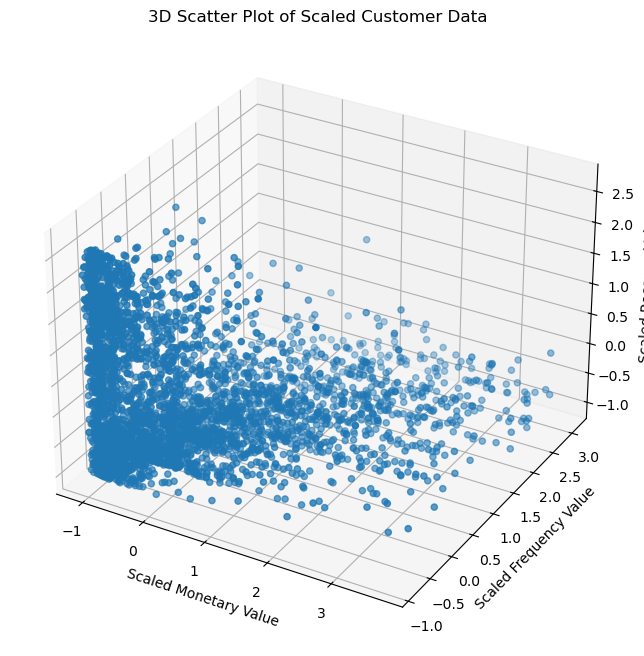

In [31]:
# set the figure
fig = plt.figure(figsize=(8, 8))

# set the axis
ax = fig.add_subplot(projection="3d")

# create the scatter
scatter = ax.scatter(scaled_data_df["MonetaryValue"], scaled_data_df["Frequency"], scaled_data_df["Recency"])

# add labels
ax.set_xlabel("Scaled Monetary Value")
ax.set_ylabel("Scaled Frequency Value")
ax.set_zlabel("Scaled Recency Value")

# set the title of the plot
ax.set_title('3D Scatter Plot of Scaled Customer Data')

# plt.savefig('3D_Scatter_Plot_of_Scaled_Customer_Data.png', dpi=300)
plt.show()

---
#### Insight: 
##### The data has kept its shape but the scale has changed and each feature is now comparable
---

#### Save scaled data as csv file

In [34]:
# scaled_data_df.to_csv("Online_transactions_cleaned_and_scaled.csv", index=False)

#### Outlier Data Cluster Analysis

In [76]:
# find the indices of the records which are present in both monetary outliers and
# frequency outliers df
overlap_indices = monetary_outliers_df.index.intersection(frequency_outliers_df.index)

# ensuring that we keep the pure monetary values separate from the pure frequency values
# and vice versa
monetary_only_outliers = monetary_outliers_df.drop(overlap_indices)
frequency_only_outliers = frequency_outliers_df.drop(overlap_indices)
monetary_and_frequency_outliers = monetary_outliers_df.loc[overlap_indices]

# Manually assign the cluster labels with the appropriate label
monetary_only_outliers['Cluster'] = -1
frequency_only_outliers['Cluster'] = -2
monetary_and_frequency_outliers['Cluster'] = -3

# Union together into one dataframe passing a list into .concat
outliers_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])

# print out the resultf
outliers_clusters_df

,CustomerID,MonetaryValue,Frequency,LastInvoiceDate,Recency,Cluster
0,12346.00,77183.60,1,2011-01-18 10:01:00,325,-1
1,12347.00,3598.21,6,2011-12-07 15:52:00,1,-1
10,12357.00,6207.67,1,2011-11-06 16:07:00,32,-1
12,12359.00,6372.58,4,2011-10-13 12:47:00,57,-1
27,12378.00,4008.62,1,2011-08-02 10:34:00,129,-1
...,...,...,...,...,...,...
4149,18198.00,5425.56,17,2011-12-05 14:49:00,3,-3
4168,18223.00,5982.85,13,2011-12-05 09:11:00,4,-3
4170,18225.00,5479.12,11,2011-12-06 13:27:00,2,-3
4171,18226.00,5228.05,11,2011-10-26 13:36:00,43,-3


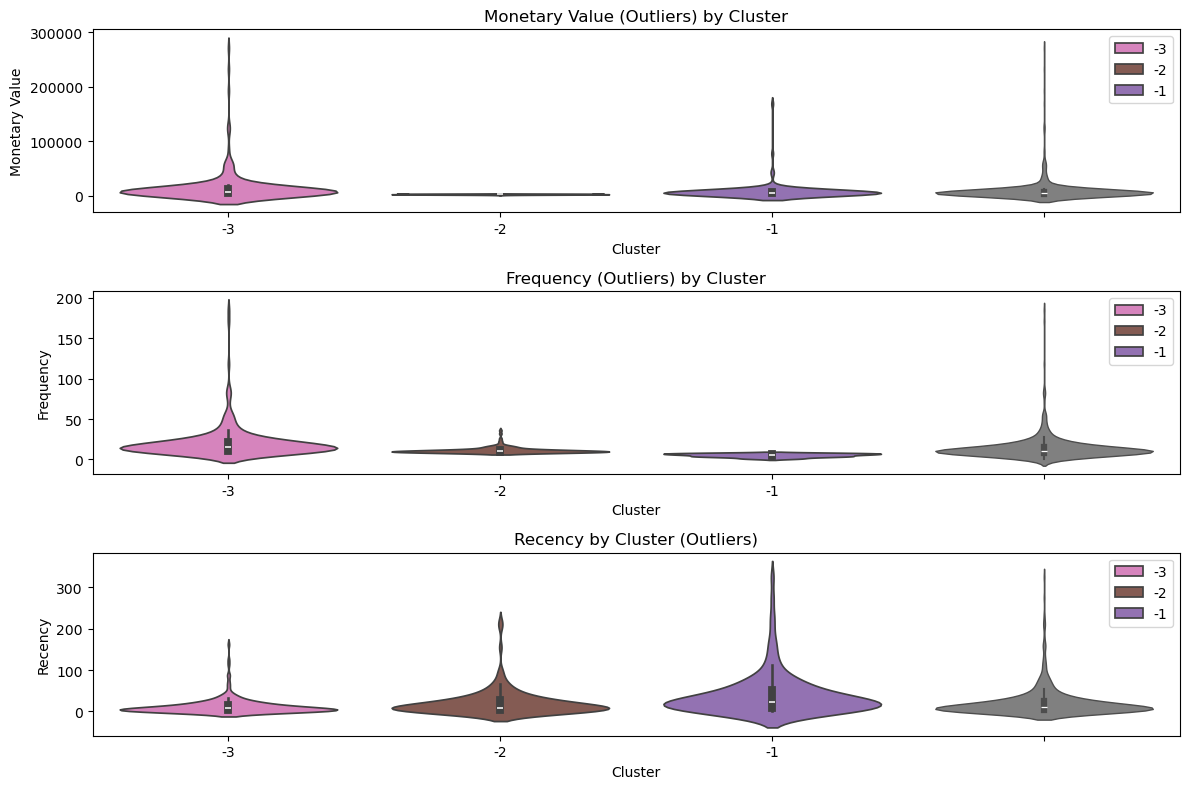

In [84]:
cluster_colors = {-1: '#9467bd',
                  -2: '#8c564b',
                  -3: '#e377c2'}

plt.figure(figsize=(12,8))
# using seaborn palette and hue together rather than color_map
plt.subplot(3,1,1)
sns.violinplot(x=outliers_clusters_df["Cluster"], y=outliers_clusters_df["MonetaryValue"], palette=cluster_colors, hue=outliers_clusters_df['Cluster'])
sns.violinplot(y=outliers_clusters_df["MonetaryValue"], color='gray', linewidth=1.0)
plt.title('Monetary Value (Outliers) by Cluster')
plt.ylabel('Monetary Value')

plt.subplot(3,1,2)
sns.violinplot(x=outliers_clusters_df["Cluster"], y=outliers_clusters_df["Frequency"], palette=cluster_colors, hue=outliers_clusters_df['Cluster'])
sns.violinplot(y=outliers_clusters_df["Frequency"], color='gray', linewidth=1.0)
plt.title('Frequency (Outliers) by Cluster')
plt.ylabel('Frequency')

plt.subplot(3,1,3)
sns.violinplot(x=outliers_clusters_df["Cluster"], y=outliers_clusters_df['Recency'], palette=cluster_colors, hue=outliers_clusters_df['Cluster'])
sns.violinplot(y=outliers_clusters_df["Recency"], color='gray', linewidth=1.0)
plt.title('Recency by Cluster (Outliers)')
plt.ylabel('Recency')

plt.tight_layout()
# plt.savefig('RFM_violinplot_outliers_distributions.png', dpi=300)
plt.show()